# Overview

In this example, we are going to predict the binding pose of a small molecule to a target protein.

PDB 6HD6 is an interesting case, in which two small molecule drugs bind to the same protein target on different binding sites.

One small molecule, STI-571, is the famous drug Imatinib. The other small molecule, FYH, is asciminib.

This PDB is also used as an exmaple by Regina Barzilay and Hannes Stärk in MLDD workshop https://www.mldd-workshop.org/home

https://www.rcsb.org/structure/6HD6

In [1]:
tankbind_src_folder_path = "../tankbind/"
import sys
sys.path.insert(0, tankbind_src_folder_path)

# input preparation.

In [2]:
from Bio.PDB.PDBList import PDBList   # pip install biopython if import failure
import os
import numpy as np
import pandas as pd
pre = "./single_PDB_6hd6/"
pdir = f"{pre}/PDBs/"
pdb = '6hd6'
os.system(f"mkdir -p {pdir}")

### protein&compound complex Structure file
pdbl = PDBList()
native_pdb = pdbl.retrieve_pdb_file(pdb, pdir=pdir, file_format='pdb')

Structure exists: './single_PDB_6hd6//PDBs/pdb6hd6.ent' 


In [3]:
# demonstrate complex Structure
import nglview   # conda install nglview -c conda-forge if import failure
view = nglview.show_file(nglview.FileStructure(native_pdb))
view

NGLWidget()

In [4]:
view.render_image()

Image(value=b'', width='99%')

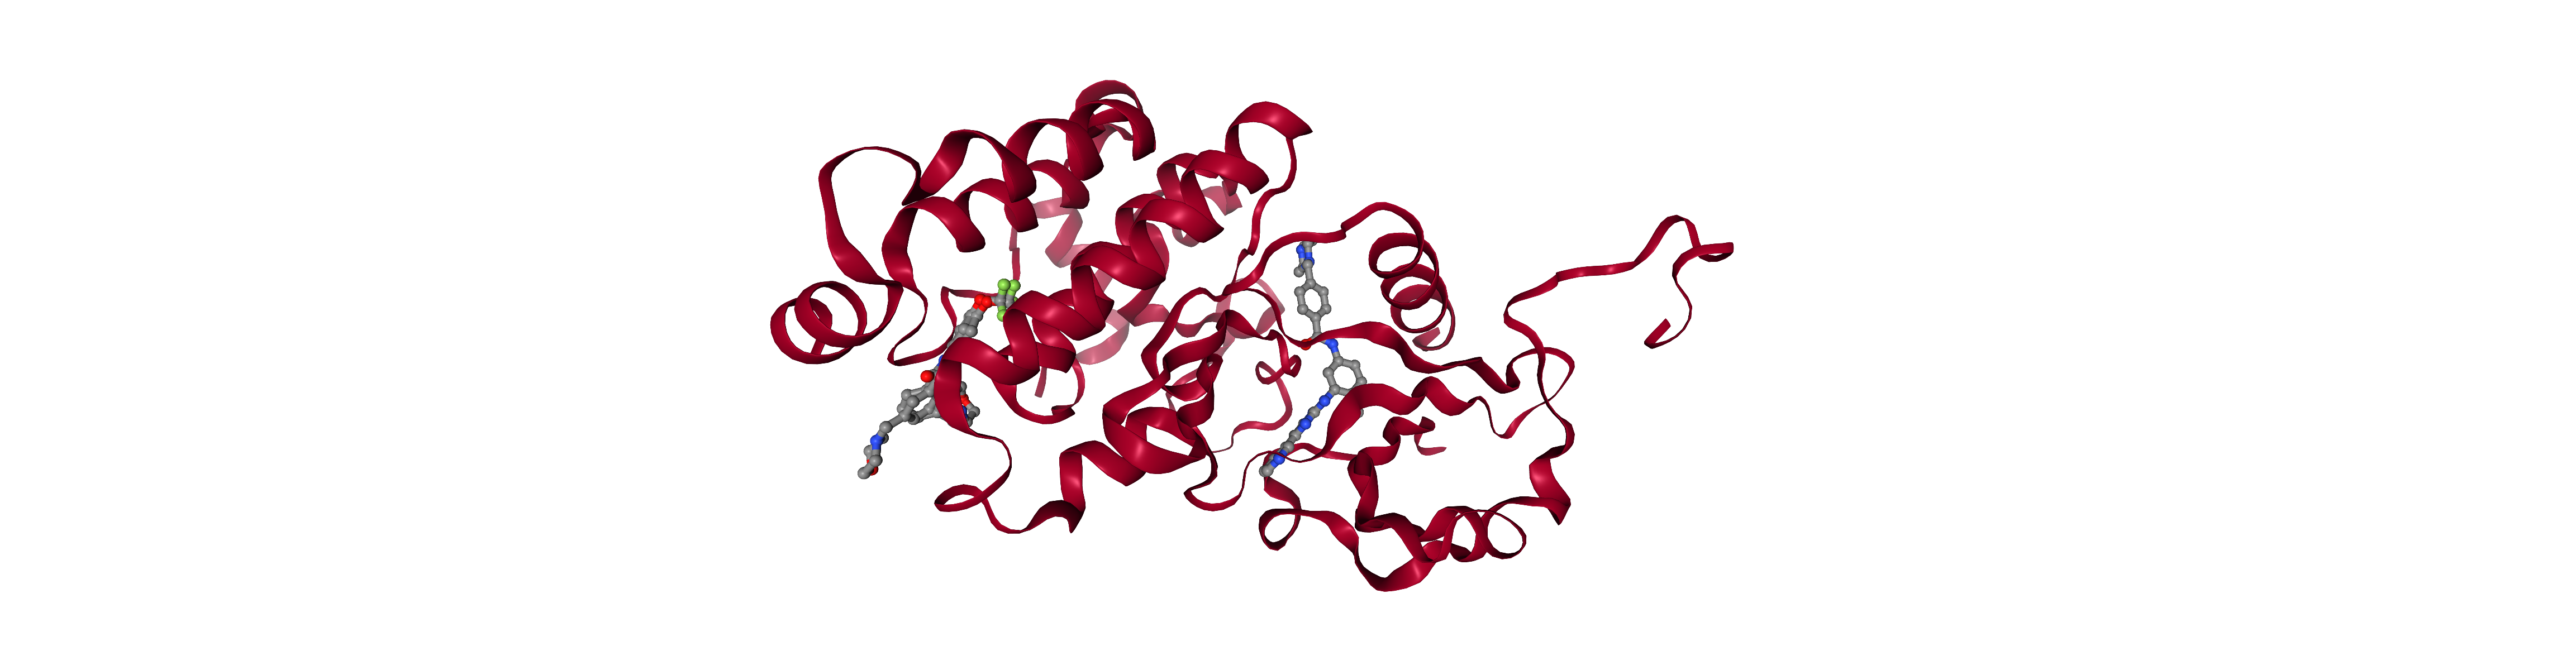

In [5]:
view._display_image()

In [7]:
from Bio.PDB import PDBParser
parser = PDBParser(QUIET=True)
s = parser.get_structure(pdb, native_pdb)

list(s.get_chains())
### 6hd6's protein has teo chain
### > [<Chain id=A>, <Chain id=B>]

[<Chain id=A>, <Chain id=B>]

In [13]:
# model 0, chain A is the chain in contact with the ligands
c = s[0]['A']
res_list = list(c.get_residues())

### checkout what res_list look like
print([res.full_id for res in res_list[:10]])

# list HETATMs
### extract compound parts
hetro_list = [res for res in res_list if (res.full_id[-1][0] != ' ' and res.full_id[-1][0] != 'W')]
hetro_list
# both FYH and STI are the ligands we are interested.

[('6hd6', 0, 'A', (' ', 243, ' ')), ('6hd6', 0, 'A', (' ', 244, ' ')), ('6hd6', 0, 'A', (' ', 245, ' ')), ('6hd6', 0, 'A', (' ', 246, ' ')), ('6hd6', 0, 'A', (' ', 247, ' ')), ('6hd6', 0, 'A', (' ', 248, ' ')), ('6hd6', 0, 'A', (' ', 249, ' ')), ('6hd6', 0, 'A', (' ', 250, ' ')), ('6hd6', 0, 'A', (' ', 251, ' ')), ('6hd6', 0, 'A', (' ', 252, ' '))]


[<Residue CL het=H_CL resseq=601 icode= >,
 <Residue FYH het=H_FYH resseq=602 icode= >,
 <Residue STI het=H_STI resseq=603 icode= >]

# get protein.pdb, ligand.sdf, ligand_from_rdkit.sdf ready

In [14]:
from feature_utils import split_protein_and_ligand

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [15]:
### seperate protein and ligand(FYH) to different file: .pdb & .sdf)
ligand_seq_id = 602
proteinFile = f"{pre}/{pdb}_protein.pdb"
ligandFile = f"{pre}/{pdb}_FYH_ligand.sdf"
clean_res_list, ligand_list = split_protein_and_ligand(c, pdb, ligand_seq_id, proteinFile, ligandFile)

In [16]:
### seperate protein and ligand(STI) to different file: .pdb & .sdf
ligand_seq_id = 603
proteinFile = f"{pre}/{pdb}_protein.pdb"
ligandFile = f"{pre}/{pdb}_STI_ligand.sdf"
clean_res_list, ligand_list = split_protein_and_ligand(c, pdb, ligand_seq_id, proteinFile, ligandFile)

### retrieve query ligand from RDkit.Chem

In [19]:
import rdkit.Chem as Chem
from feature_utils import generate_sdf_from_smiles_using_rdkit

In [23]:
# we also generated a sdf file using RDKit.
ligandFile = f"{pre}/{pdb}_STI_ligand.sdf"
smiles = Chem.MolToSmiles(Chem.MolFromMolFile(ligandFile))
print(f"STI: {smiles}")
rdkitMolFile = f"{pre}/{pdb}_STI_mol_from_rdkit.sdf"
shift_dis = 0   # for visual only, could be any number, shift the ligand away from the protein.
generate_sdf_from_smiles_using_rdkit(smiles, rdkitMolFile, shift_dis=shift_dis)

STI: Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc(-c2cccnc2)n1


In [24]:
# we also generated a sdf file using RDKit.
ligandFile = f"{pre}/{pdb}_FYH_ligand.sdf"
smiles = Chem.MolToSmiles(Chem.MolFromMolFile(ligandFile))
print(f"FYH: {smiles}")
rdkitMolFile = f"{pre}/{pdb}_FYH_mol_from_rdkit.sdf"
shift_dis = 0   # for visual only, could be any number, shift the ligand away from the protein.
generate_sdf_from_smiles_using_rdkit(smiles, rdkitMolFile, shift_dis=shift_dis)

FYH: O=C(Nc1ccc(OC(F)(F)F)cc1)c1cccc(CN2CCOCC2)c1


In [26]:
### demonstrate protein and ligand's target_position(yellow) & original_position(red)
view = nglview.show_file(nglview.FileStructure(proteinFile), default=False)
view.add_representation('cartoon', selection='protein', color='white')
rdkit = view.add_component(nglview.FileStructure(rdkitMolFile), default=False)
rdkit.add_ball_and_stick(color='red')
native = view.add_component(nglview.FileStructure(ligandFile), default=False)
native.add_ball_and_stick(color='yellow')
view

NGLWidget()

In [27]:
# red is mol generated using RDKit, yellow is the native ligand.
view.render_image()

Image(value=b'', width='99%')

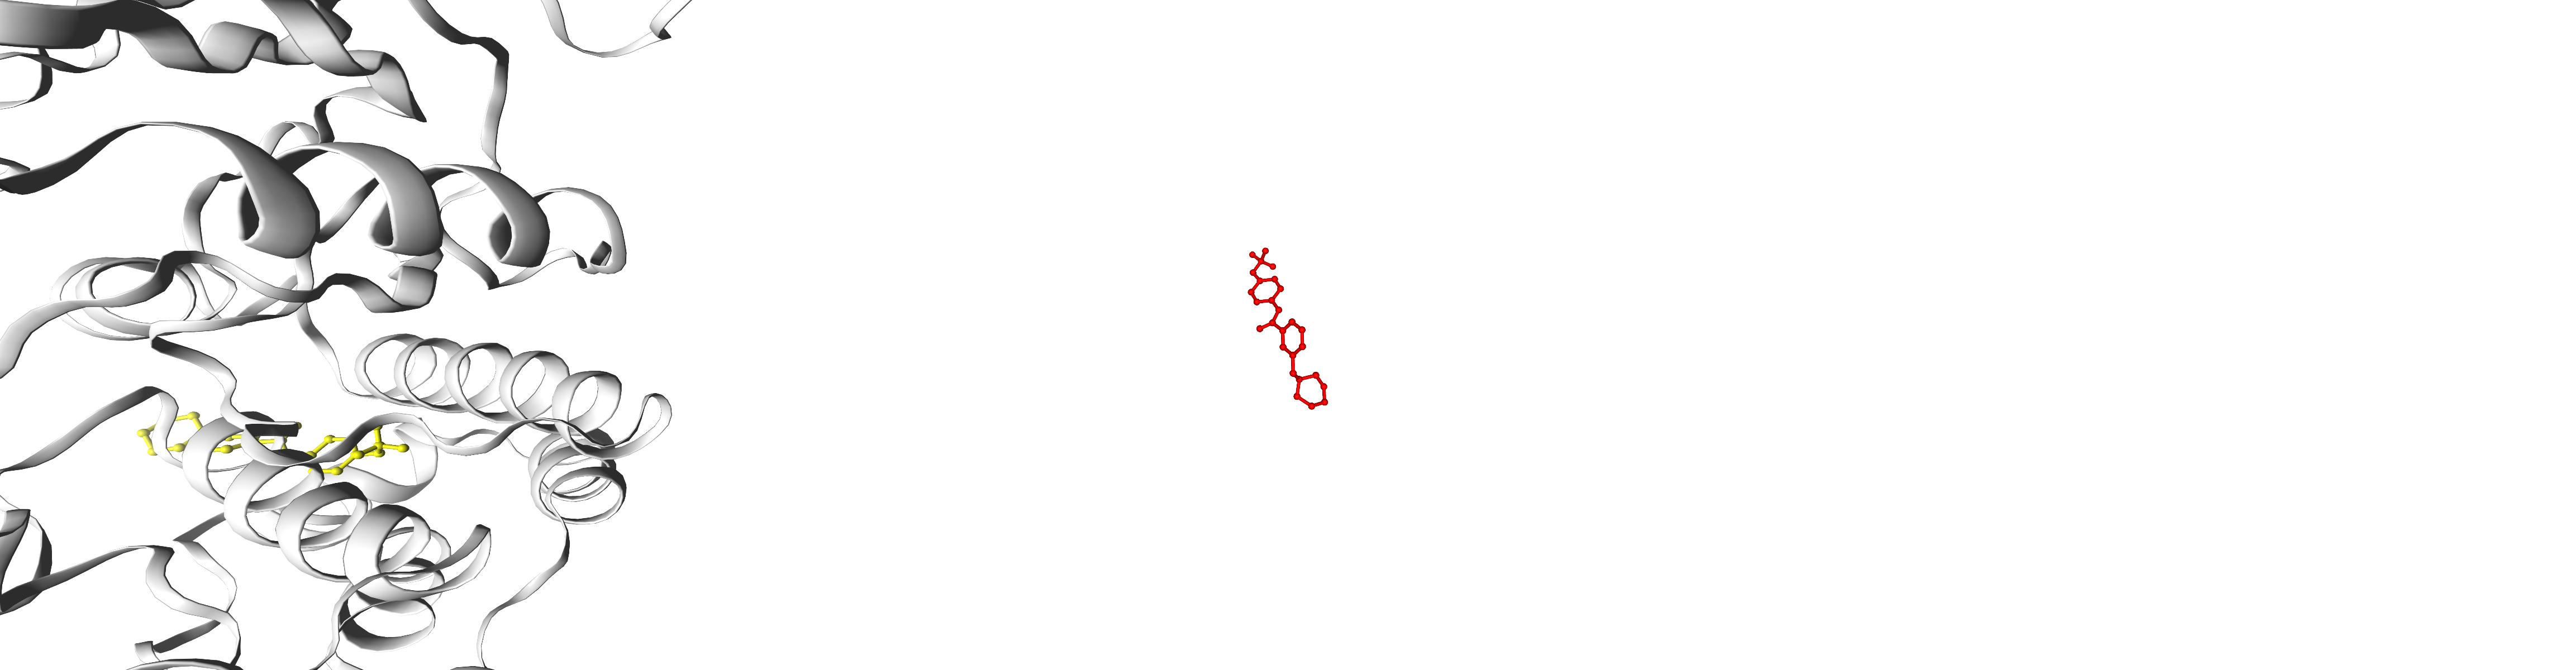

In [28]:
view._display_image()

# get protein feature

In [32]:
from feature_utils import get_protein_feature

parser = PDBParser(QUIET=True)
s = parser.get_structure("x", proteinFile)
res_list = list(s.get_residues())

protein_dict = {}
protein_dict[pdb] = get_protein_feature(res_list)

protein_feature = protein_dict['6hd6']
print(f"> protein_features (size: {len(protein_feature)}): ")
for feature in protein_feature:
    print(feature.shape)
protein_feature

> protein_features (size: 7): 
torch.Size([285, 3])
torch.Size([285])
torch.Size([285, 6])
torch.Size([285, 3, 3])
torch.Size([2, 8550])
torch.Size([8550, 32])
torch.Size([8550, 1, 3])


(tensor([[ 2.1942e+01, -9.1900e+00,  4.6384e+01],
         [ 2.4735e+01, -6.6200e+00,  4.5726e+01],
         [ 2.5318e+01, -7.8250e+00,  4.2160e+01],
         [ 2.3445e+01, -6.3220e+00,  3.9164e+01],
         [ 2.2456e+01, -9.9320e+00,  3.8311e+01],
         [ 2.0187e+01, -1.0323e+01,  4.1413e+01],
         [ 1.6379e+01, -9.7220e+00,  4.1357e+01],
         [ 1.6970e+01, -8.1650e+00,  4.4812e+01],
         [ 1.9410e+01, -5.5080e+00,  4.3467e+01],
         [ 1.9136e+01, -1.9060e+00,  4.4589e+01],
         [ 2.1667e+01,  6.0500e-01,  4.3202e+01],
         [ 2.1285e+01,  2.6550e+00,  4.6392e+01],
         [ 2.2268e+01, -2.0100e-01,  4.8716e+01],
         [ 2.5872e+01, -5.8000e-02,  4.9804e+01],
         [ 2.8458e+01, -2.0460e+00,  5.1771e+01],
         [ 2.8303e+01, -9.7400e-01,  5.5415e+01],
         [ 3.2008e+01, -1.9110e+00,  5.5782e+01],
         [ 3.2801e+01,  5.8600e-01,  5.3027e+01],
         [ 3.2043e+01,  3.3350e+00,  5.5547e+01],
         [ 3.4130e+01,  4.2700e+00,  5.8574e+01],


# get compound feature: from the one with original_position

In [33]:
from feature_utils import extract_torchdrug_feature_from_mol

compound_dict = {}
for ligandName in ['STI', 'FYH']:
    rdkitMolFile = f"{pre}/{pdb}_{ligandName}_mol_from_rdkit.sdf"
    mol = Chem.MolFromMolFile(rdkitMolFile)
    compound_dict[pdb+f"_{ligandName}"+"_rdkit"] = extract_torchdrug_feature_from_mol(mol, has_LAS_mask=True)

compound_feature = compound_dict['6hd6_FYH_rdkit']
print(f"> compound_feature (size: {len(compound_feature)}): ")
for feature in compound_feature:
    print(feature.shape)
compound_feature


> compound_feature (size: 5): 
(27, 3)
torch.Size([27, 56])
torch.Size([58, 3])
torch.Size([58, 19])
torch.Size([27, 27, 16])


(array([[ 1.5350e+00,  1.1986e+00,  1.6152e+00],
        [ 1.3476e+00,  8.0300e-02,  1.1529e+00],
        [ 2.2181e+00, -6.5390e-01,  3.6710e-01],
        [ 3.5306e+00, -3.0410e-01, -1.0200e-02],
        [ 4.1958e+00,  8.3400e-01,  4.4020e-01],
        [ 5.5036e+00,  1.1022e+00,  1.9000e-02],
        [ 6.1698e+00,  2.4050e-01, -8.5510e-01],
        [ 7.4372e+00,  6.2950e-01, -1.1782e+00],
        [ 8.1765e+00, -1.9480e-01, -2.0614e+00],
        [ 7.5670e+00, -2.9470e-01, -3.2624e+00],
        [ 8.3539e+00, -1.4295e+00, -1.5434e+00],
        [ 9.3949e+00,  3.5740e-01, -2.2543e+00],
        [ 5.5092e+00, -9.0060e-01, -1.3054e+00],
        [ 4.1998e+00, -1.1694e+00, -8.8370e-01],
        [ 3.9300e-02, -5.8230e-01,  1.4117e+00],
        [-4.5900e-02, -1.9555e+00,  1.6726e+00],
        [-1.2897e+00, -2.5411e+00,  1.9128e+00],
        [-2.4469e+00, -1.7594e+00,  1.9017e+00],
        [-2.3740e+00, -3.8020e-01,  1.6592e+00],
        [-3.6232e+00,  4.7590e-01,  1.6580e+00],
        [-3.9187e+00

In [34]:
compound_dict.keys()

dict_keys(['6hd6_STI_rdkit', '6hd6_FYH_rdkit'])

# Generate dataset with query pocket: p2rank segmentation

In [35]:
pdb_list = [pdb]
ds = f"{pre}/protein_list.ds"
with open(ds, "w") as out:
    for pdb in pdb_list:
        out.write(f"./{pdb}_protein.pdb\n")


In [36]:
p2rank = "bash /home/zoujl/TankBind/packages/p2rank_2.3/prank"
cmd = f"{p2rank} predict {ds} -o {pre}/p2rank -threads 1"
os.system(cmd)

----------------------------------------------------------------------------------------------
 P2Rank 2.3
----------------------------------------------------------------------------------------------

predicting pockets for proteins from dataset [protein_list.ds]
processing [6hd6_protein.pdb] (1/1)
predicting pockets finished in 0 hours 0 minutes 9.748 seconds
results saved to directory [/home/zoujl/TankBind/examples/single_PDB_6hd6/p2rank]

----------------------------------------------------------------------------------------------
 finished successfully in 0 hours 0 minutes 10.805 seconds
----------------------------------------------------------------------------------------------


0

In [37]:
info = []
for pdb in pdb_list:
    for compound_name in list(compound_dict.keys()):
        # use protein center as the block center.
        com = ",".join([str(a.round(3)) for a in protein_dict[pdb][0].mean(axis=0).numpy()])
        info.append([pdb, compound_name, "protein_center", com])

        p2rankFile = f"{pre}/p2rank/{pdb}_protein.pdb_predictions.csv"
        pocket = pd.read_csv(p2rankFile)
        pocket.columns = pocket.columns.str.strip()
        pocket_coms = pocket[['center_x', 'center_y', 'center_z']].values
        for ith_pocket, com in enumerate(pocket_coms):
            com = ",".join([str(a.round(3)) for a in com])
            info.append([pdb, compound_name, f"pocket_{ith_pocket+1}", com])
info = pd.DataFrame(info, columns=['protein_name', 'compound_name', 'pocket_name', 'pocket_com'])
info

,protein_name,compound_name,pocket_name,pocket_com
0,6hd6,6hd6_STI_rdkit,protein_center,"15.746,23.565,54.818"
1,6hd6,6hd6_STI_rdkit,pocket_1,"20.691,16.697,56.311"
2,6hd6,6hd6_STI_rdkit,pocket_2,"20.243,41.418,52.346"
3,6hd6,6hd6_STI_rdkit,pocket_3,"10.161,15.802,61.654"
4,6hd6,6hd6_STI_rdkit,pocket_4,"14.8,30.117,65.358"
5,6hd6,6hd6_STI_rdkit,pocket_5,"18.961,28.224,40.251"
6,6hd6,6hd6_STI_rdkit,pocket_6,"32.53,30.08,55.506"
7,6hd6,6hd6_STI_rdkit,pocket_7,"-1.333,28.528,67.874"
8,6hd6,6hd6_STI_rdkit,pocket_8,"14.41,1.211,50.949"
9,6hd6,6hd6_FYH_rdkit,protein_center,"15.746,23.565,54.818"


### construct dataset

In [38]:
import torch
torch.set_num_threads(1)

from data import TankBind_prediction

In [39]:
dataset_path = f"{pre}/{pdb}_dataset/"
os.system(f"rm -r {dataset_path}")
os.system(f"mkdir -p {dataset_path}")
dataset = TankBind_prediction(dataset_path, data=info, protein_dict=protein_dict, compound_dict=compound_dict)


['single_PDB_6hd6/6hd6_dataset/processed/data.pt', 'single_PDB_6hd6/6hd6_dataset/processed/protein.pt', 'single_PDB_6hd6/6hd6_dataset/processed/compound.pt']


Processing...
Done!


In [42]:
dataset[5]

### only contain protein and compound's positional and feature infomation

# HeteroData(
#   dis_map=[3626],   # unmeaningful
#   node_xyz=[98, 3], # coords of protein_node (residue)
#   coords=[37, 3],   # coords of compound_node (atom)
#   y=[3626],         # unmeaningful
#   seq=[98],         # encoded protein residue sequence
#   compound_pair=[1369, 16],         # compound's atom-pair distance (atom_num*atom_num, 16)
#   protein={
#     node_s=[98, 6],         # scale feature of node (res_num, 6)
#     node_v=[98, 3, 3],      # vector feature of node (res_num, 2+1, 3)
#   },
#   compound={ x=[37, 56] },  # features of compound node (atom_num, 56)
#   (protein, p2p, protein)={
#     edge_index=[2, 2227],   # edges that link protein nodes with the top_k(default: 30) nearest neighbors (2, edge_num)
#     edge_s=[2227, 32],      # scale feature of edge (edge_num, 32)
#     edge_v=[2227, 1, 3],    # vector feature of edge (edge_num, 1, 3)
#   },
#   (compound, c2c, compound)={
#     edge_index=[2, 82],     # edges that link compound nodes, computed by torch_drug.Molecule (2, edge_num)
#     edge_weight=[82],       # a tensor of 1 (edge_num)
#     edge_attr=[82, 19],     # feature of compound's atom edge
#   }
# )


HeteroData(
  dis_map=[3626],
  node_xyz=[98, 3],
  coords=[37, 3],
  y=[3626],
  seq=[98],
  compound_pair=[1369, 16],
  protein={
    node_s=[98, 6],
    node_v=[98, 3, 3],
  },
  compound={ x=[37, 56] },
  (protein, p2p, protein)={
    edge_index=[2, 2227],
    edge_s=[2227, 32],
    edge_v=[2227, 1, 3],
  },
  (compound, c2c, compound)={
    edge_index=[2, 82],
    edge_weight=[82],
    edge_attr=[82, 19],
  }
)

In [43]:
dataset_path = f"{pre}/{pdb}_dataset/"
dataset = TankBind_prediction(dataset_path)

['single_PDB_6hd6/6hd6_dataset/processed/data.pt', 'single_PDB_6hd6/6hd6_dataset/processed/protein.pt', 'single_PDB_6hd6/6hd6_dataset/processed/compound.pt']


# Predict target position of ligand

In [44]:
import logging
from torch_geometric.loader import DataLoader
from tqdm import tqdm    # pip install tqdm if fails.
from model import get_model
from utils import *

In [48]:
batch_size = 5
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device= 'cpu'
logging.basicConfig(level=logging.INFO)

### load pre-trained model
model = get_model(0, logging, device)
# re-dock model
# modelFile = "../saved_models/re_dock.pt"
# self-dock model
modelFile = "../saved_models/self_dock.pt"
model.load_state_dict(torch.load(modelFile, map_location=device))
_ = model.eval()

###
data_loader = DataLoader(dataset, batch_size=batch_size, follow_batch=['x', 'y', 'compound_pair'], shuffle=False, num_workers=8)
affinity_pred_list = []
y_pred_list = []
for data in tqdm(data_loader):
    data = data.to(device)
    y_pred, affinity_pred = model(data)
    affinity_pred_list.append(affinity_pred.detach().cpu())
    for i in range(data.y_batch.max() + 1):
        y_pred_list.append((y_pred[data['y_batch'] == i]).detach().cpu())

affinity_pred_list = torch.cat(affinity_pred_list)


04:37:02   5 stack, readout2, pred dis map add self attention and GVP embed, compound model GIN


100%|██████████| 4/4 [00:16<00:00,  4.23s/it]


In [49]:
for y in y_pred_list:
    print(y.shape)

torch.Size([6216])
torch.Size([5254])
torch.Size([4181])
torch.Size([4551])
torch.Size([4329])
torch.Size([3626])
torch.Size([2590])
torch.Size([2775])
torch.Size([2738])
torch.Size([4536])
torch.Size([3834])
torch.Size([3051])
torch.Size([3321])
torch.Size([3159])
torch.Size([2646])
torch.Size([1890])
torch.Size([2025])
torch.Size([1998])


In [50]:
for affinity in affinity_pred_list:
    print(affinity)

tensor(8.0342)
tensor(7.8899)
tensor(5.5848)
tensor(7.6809)
tensor(4.6103)
tensor(2.3749)
tensor(6.4905)
tensor(3.2221)
tensor(5.4053)
tensor(6.2590)
tensor(6.1592)
tensor(6.7735)
tensor(5.8151)
tensor(3.4986)
tensor(2.3234)
tensor(3.0076)
tensor(2.5970)
tensor(4.2233)


In [51]:
info = dataset.data
info['affinity'] = affinity_pred_list
info

,protein_name,compound_name,pocket_name,pocket_com,affinity
0,6hd6,6hd6_STI_rdkit,protein_center,"15.746,23.565,54.818",8.034209
1,6hd6,6hd6_STI_rdkit,pocket_1,"20.691,16.697,56.311",7.889901
2,6hd6,6hd6_STI_rdkit,pocket_2,"20.243,41.418,52.346",5.584842
3,6hd6,6hd6_STI_rdkit,pocket_3,"10.161,15.802,61.654",7.680916
4,6hd6,6hd6_STI_rdkit,pocket_4,"14.8,30.117,65.358",4.610328
5,6hd6,6hd6_STI_rdkit,pocket_5,"18.961,28.224,40.251",2.374916
6,6hd6,6hd6_STI_rdkit,pocket_6,"32.53,30.08,55.506",6.490473
7,6hd6,6hd6_STI_rdkit,pocket_7,"-1.333,28.528,67.874",3.222052
8,6hd6,6hd6_STI_rdkit,pocket_8,"14.41,1.211,50.949",5.405342
9,6hd6,6hd6_FYH_rdkit,protein_center,"15.746,23.565,54.818",6.258986


In [52]:
info.to_csv(f"{pre}/info_with_predicted_affinity.csv")

In [53]:
### choose the most likely one for each ligand
chosen = info.loc[info.groupby(['protein_name', 'compound_name'],sort=False)['affinity'].agg('idxmax')].reset_index()
chosen

,index,protein_name,compound_name,pocket_name,pocket_com,affinity
0,0,6hd6,6hd6_STI_rdkit,protein_center,"15.746,23.565,54.818",8.034209
1,11,6hd6,6hd6_FYH_rdkit,pocket_2,"20.243,41.418,52.346",6.773487


# from predicted interaction distance map to sdf

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
from generation_utils import get_LAS_distance_constraint_mask, get_info_pred_distance, write_with_new_coords
device = 'cpu'
for i, line in chosen.iterrows():
    idx = line['index']
    pocket_name = line['pocket_name']
    compound_name = line['compound_name']
    ligandName = compound_name.split("_")[1]
    coords = dataset[idx].coords.to(device)
    protein_nodes_xyz = dataset[idx].node_xyz.to(device)
    n_compound = coords.shape[0]
    n_protein = protein_nodes_xyz.shape[0]
    y_pred = y_pred_list[idx].reshape(n_protein, n_compound).to(device)
    y = dataset[idx].dis_map.reshape(n_protein, n_compound).to(device)
    compound_pair_dis_constraint = torch.cdist(coords, coords)
    rdkitMolFile = f"{pre}/{pdb}_{ligandName}_mol_from_rdkit.sdf"
    mol = Chem.MolFromMolFile(rdkitMolFile)
    LAS_distance_constraint_mask = get_LAS_distance_constraint_mask(mol).bool()
    info = get_info_pred_distance(coords, y_pred, protein_nodes_xyz, compound_pair_dis_constraint, 
                                  LAS_distance_constraint_mask=LAS_distance_constraint_mask,
                                  n_repeat=1, show_progress=False)

    result_folder = f'{pre}/{pdb}_result/'
    os.system(f'mkdir -p {result_folder}')
    # toFile = f'{result_folder}/{ligandName}_{pocket_name}_tankbind.sdf'
    toFile = f'{result_folder}/{ligandName}_tankbind.sdf'
    # print(toFile)
    new_coords = info.sort_values("loss")['coords'].iloc[0].astype(np.double)
    write_with_new_coords(mol, new_coords, toFile)

In [56]:
view = nglview.show_file(nglview.FileStructure(proteinFile), default=False)
view.add_representation('cartoon', selection='protein', color='white')


for ligandName in ['STI', 'FYH']:
    predictedFile = f'{result_folder}/{ligandName}_tankbind.sdf'
    rdkit = view.add_component(nglview.FileStructure(predictedFile), default=False)
    rdkit.add_ball_and_stick(color='red')
    ligandFile = f"{pre}/{pdb}_{ligandName}_ligand.sdf"
    native = view.add_component(nglview.FileStructure(ligandFile), default=False)
    native.add_ball_and_stick(color='yellow')
view

NGLWidget()

In [59]:
# red is prediction starting from mol generated using RDKit, yellow is the native ligand.
view.render_image()

Image(value=b'', width='99%')

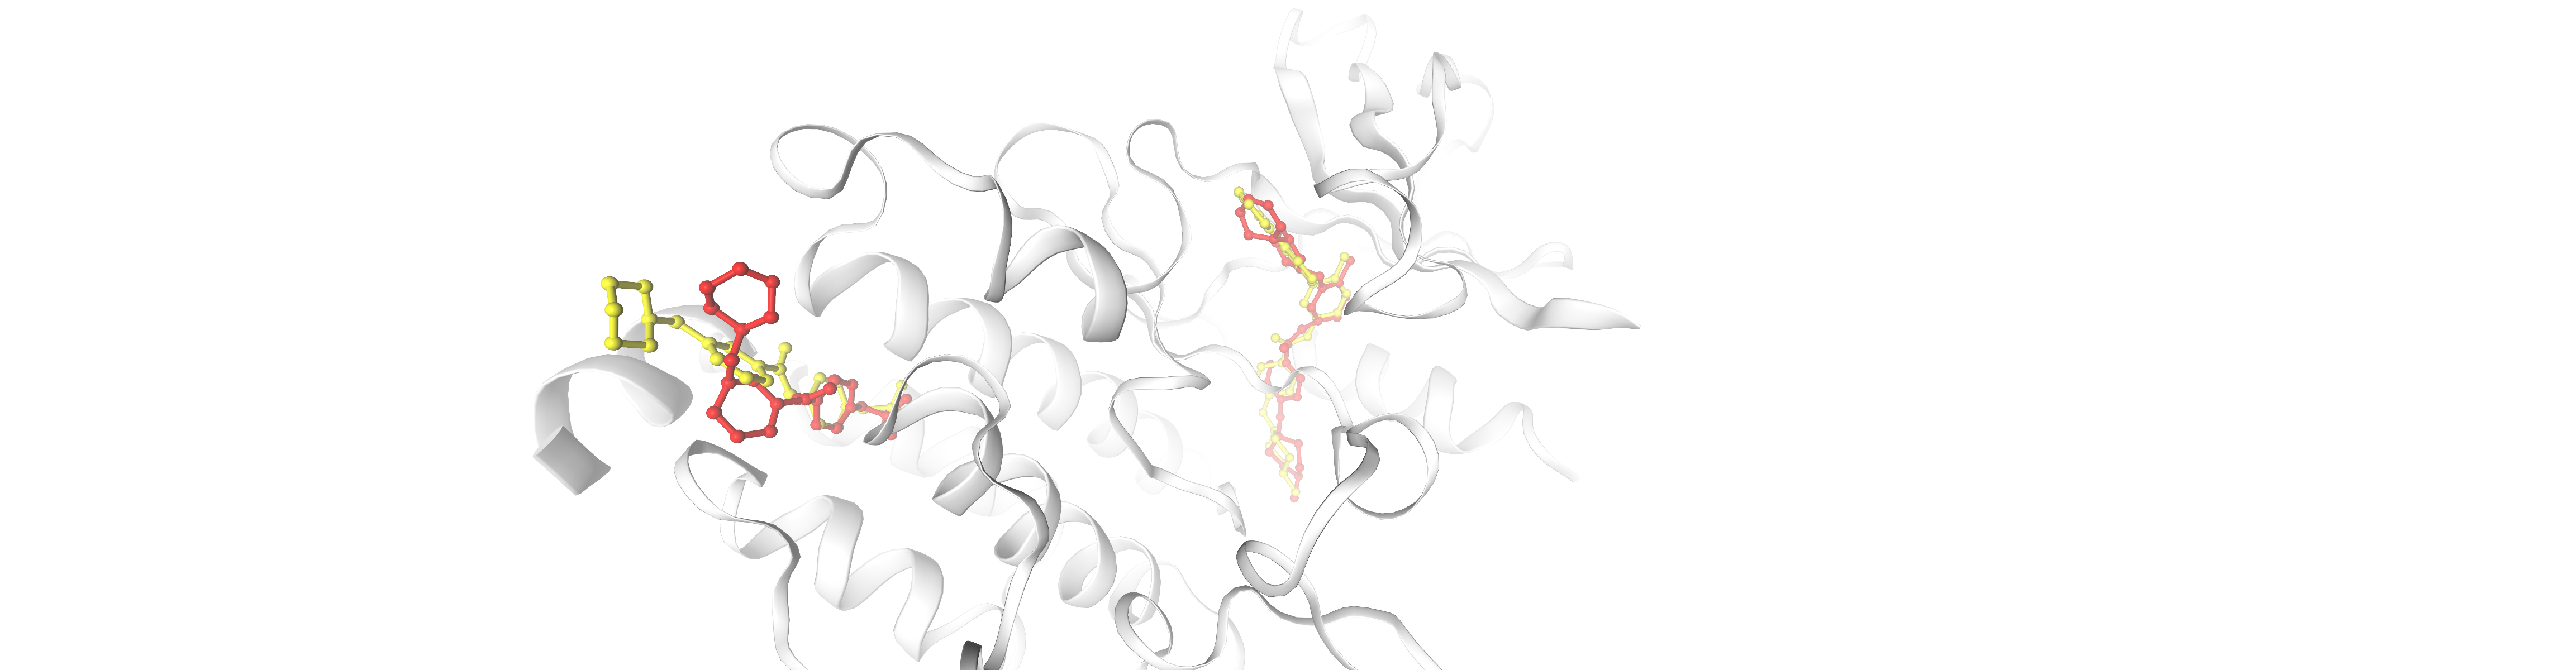

In [60]:
view._display_image()